# Quantifying Interlingua Across Metrics and Pooling Types

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [139]:
import torch
import numpy as np

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
from datasets import load_dataset

from util import encode_batch

In [4]:
# 1- load the model the tokenizer
hf_model_id = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model = AutoModel.from_pretrained(hf_model_id)

_ = model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
langs = ['en', 'fr', 'de', 'et', 'ru']

In [6]:
datasets = {}
for l in langs:
    datasets[l] = load_dataset('csv', 
                               delimiter='\t',
                               header=0,
                               quoting=3,
                               data_files=f"../experiments/multilingual/xnli_extension/data/multinli.train.{l}.tsv",
                               split='train[0:10000]')

Using custom data configuration default-e88fcd2517069a4d
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-e88fcd2517069a4d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-e3dda5d3fce092d1
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-e3dda5d3fce092d1/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-1bd607b7aa1a4f75
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-1bd607b7aa1a4f75/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)
Using custom data configuration default-76b0f6a318f5e020


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-76b0f6a318f5e020/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


Using custom data configuration default-32db336b4c4e85b8
Reusing dataset csv (/gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-32db336b4c4e85b8/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


In [7]:
from scipy import spatial, stats
from collections import defaultdict
from sklearn.metrics import f1_score, accuracy_score

In [8]:
def compute_cosine_gpu(a, b):
    a, b = torch.Tensor(a), torch.Tensor(b)
    a, b = a.to(model.device), b.to(model.device)
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1))
    return res.cpu().numpy()

In [9]:
%%time

mean_f1s = defaultdict(list)
cls_f1s = defaultdict(list)
token1_f1s = defaultdict(list)

mean_cosmatrix = defaultdict(list)
cls_cosmatrix = defaultdict(list)
token1_cosmatrix = defaultdict(list)


src = datasets["en"].map(function=encode_batch, fn_kwargs={'field': 'hypo', 
                                                                     'tokenizer': tokenizer, 
                                                                     'model': model,
                                                                     'detok': True,
                                                                     'lang_code': "en",
                                                                     "encode_token1": True},
                              batched=True,
                              batch_size=3000)

for lang in langs:
    print(lang)

    if lang == "en":
        continue

    tgt = datasets[lang].map(function=encode_batch, fn_kwargs={'field': 'hypo', 
                                                                         'tokenizer': tokenizer, 
                                                                         'model': model, 
                                                                         'detok': True, 
                                                                         'lang_code': lang,
                                                                         "encode_token1": True},
                                  batched=True,
                                  batch_size=3000)

    num_layers=13

    for l in range(num_layers):
        print(f"l{l}", end = ' ')
        d = compute_cosine_gpu(src[f'mean_{l}'], tgt[f'mean_{l}'])
        s = accuracy_score(list(range(len(d))), d.argmax(axis=1))
        mean_f1s[lang].append(s)
        mean_cosmatrix[lang].append(d)
        
        d = compute_cosine_gpu(src[f'cls_{l}'], tgt[f'cls_{l}'])
        s = accuracy_score(list(range(len(d))), d.argmax(axis=1))
        cls_f1s[lang].append(s)
        cls_cosmatrix[lang].append(d)
    
        d = compute_cosine_gpu(src[f'token1_{l}'], tgt[f'token1_{l}'])
        s = accuracy_score(list(range(len(d))), d.argmax(axis=1))
        token1_f1s[lang].append(s)
        token1_cosmatrix[lang].append(d)

  0%|          | 0/4 [00:00<?, ?ba/s]

en
fr


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 de


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 et


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 ru


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 CPU times: user 17min 23s, sys: 1min 5s, total: 18min 28s
Wall time: 18min 48s


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
mean_df = pd.DataFrame(mean_f1s)
mean_df.columns = [k.split(".")[-1] for k in mean_df.columns]

cls_df = pd.DataFrame(cls_f1s)
cls_df.columns = [k.split(".")[-1] for k in cls_df.columns]

token1_df = pd.DataFrame(token1_f1s)
token1_df.columns = [k.split(".")[-1] for k in mean_df.columns]

In [12]:
mean_df["layer"] = mean_df.index
cls_df["layer"] = cls_df.index
token1_df["layer"] = token1_df.index

In [13]:
mean_df["pooling"] = "mean"
cls_df["pooling"] = "cls"
token1_df["pooling"] = "1st_token"

In [14]:
mean_df = mean_df.melt(value_vars=[l for l in langs if l != "en"], id_vars=["layer", "pooling"], var_name='lang', value_name='accuracy')
cls_df = cls_df.melt(value_vars=[l for l in langs if l != "en"], id_vars=["layer", "pooling"], var_name='lang', value_name='accuracy')
token1_df = token1_df.melt(value_vars=[l for l in langs if l != "en"], id_vars=["layer", "pooling"], var_name='lang', value_name='accuracy')

In [18]:
task_df = pd.concat([token1_df, cls_df, mean_df])

In [19]:
task_df.to_csv(f"../assets/acc_simscore_{hf_model_id}.csv", index=False)

## Load CSV and plot

In [20]:
task_df = pd.read_csv(f"../assets/acc_simscore_{hf_model_id}.csv")

In [107]:
sns.set(font_scale=1.5) 
sns.set_style("ticks")

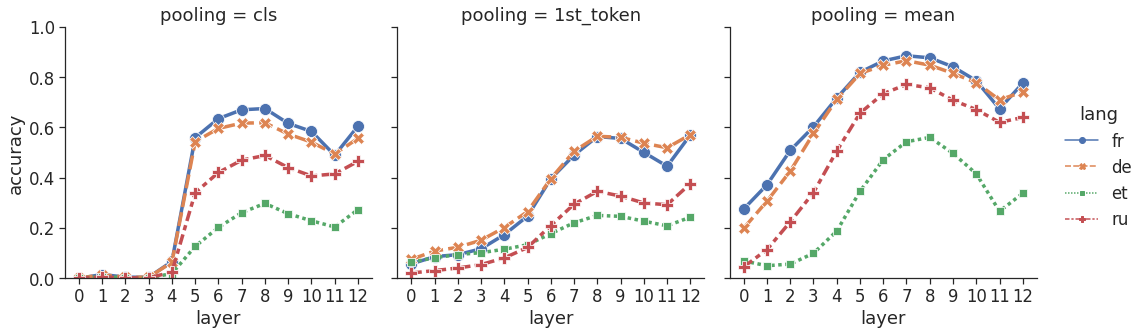

In [121]:
g = sns.relplot(data=task_df, 
            x="layer", 
            y="accuracy", 
            hue="lang", 
            style="lang", 
            markers=True, 
            col="pooling", 
            kind="line", 
            col_order=["cls", "1st_token", "mean"],
            linewidth=3.5,
            markersize=12)


plt.xticks(range(13))
plt.ylim(0,1)

g.tight_layout()

g.figure.savefig(f"../assets/top1_sim-xnli-{hf_model_id}.pdf", dpi=300)

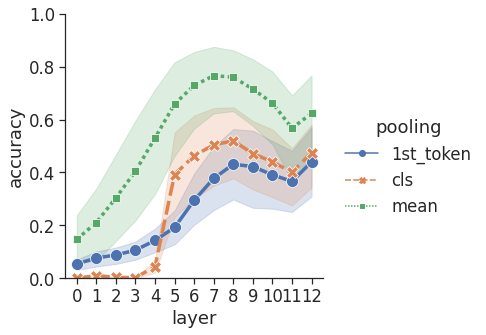

In [122]:
g = sns.relplot(data=task_df, 
            x="layer", 
            y="accuracy", 
            hue="pooling", 
            style="pooling", 
            markers=True, 
            kind="line",
            linewidth=3.5,
            markersize=12)


plt.xticks(range(13))
plt.ylim(0,1)

g.tight_layout()

g.figure.savefig(f"../assets/top1_sim-xnli-{hf_model_id}-all_together.pdf", dpi=300)

# Cosine scores

In [23]:
import pickle

In [24]:
with open("../assets/mean_cosmatrix.pkl", "wb") as f:
    pickle.dump(mean_cosmatrix, f)
    
with open("../assets/cls_cosmatrix.pkl", "wb") as f:
    pickle.dump(cls_cosmatrix, f)
    
with open("../assets/token1_cosmatrix.pkl", "wb") as f:
    pickle.dump(token1_cosmatrix, f)

In [25]:
def to_cos_df(d, pooling, target):
    d = pd.DataFrame(d)
    d["layer"] = list(range(len(d)))
    d["pooling"] = pooling
    d["target"] = target
    return d.melt(value_vars=[l for l in langs if l != "en"], id_vars=["layer", "pooling", "target"], var_name='lang', value_name='cosine_sim')



In [28]:
%%time
#
pos = defaultdict(list)
neg = defaultdict(list)

for lang in [l for l in langs if l != "en"]:
    cosmatrix = mean_cosmatrix
    
    for m in cosmatrix[lang]:
        pos[lang].append(m.diagonal().mean())
        neg[lang].append(m.mean())

mean_df = pd.concat([to_cos_df(pos, "mean", "parallel"), to_cos_df(neg, "mean", "random")])

#
pos = defaultdict(list)
neg = defaultdict(list)

for lang in [l for l in langs if l != "en"]:
    cosmatrix = cls_cosmatrix
    
    for m in cosmatrix[lang]:
        pos[lang].append(m.diagonal().mean())
        neg[lang].append(m.mean())

cls_df = pd.concat([to_cos_df(pos, "cls", "parallel"), to_cos_df(neg, "cls", "random")]) 

#
pos = defaultdict(list)
neg = defaultdict(list)

for lang in [l for l in langs if l != "en"]:
    cosmatrix = token1_cosmatrix
    
    for m in cosmatrix[lang]:
        pos[lang].append(m.diagonal().mean())
        neg[lang].append(m.mean())

token1_df = pd.concat([to_cos_df(pos, "1st_token", "parallel"), to_cos_df(neg, "1st_token", "random")]) 

CPU times: user 7.46 s, sys: 7.62 s, total: 15.1 s
Wall time: 15.1 s


In [29]:
cos_df = pd.concat([token1_df, cls_df, mean_df], ignore_index=True)

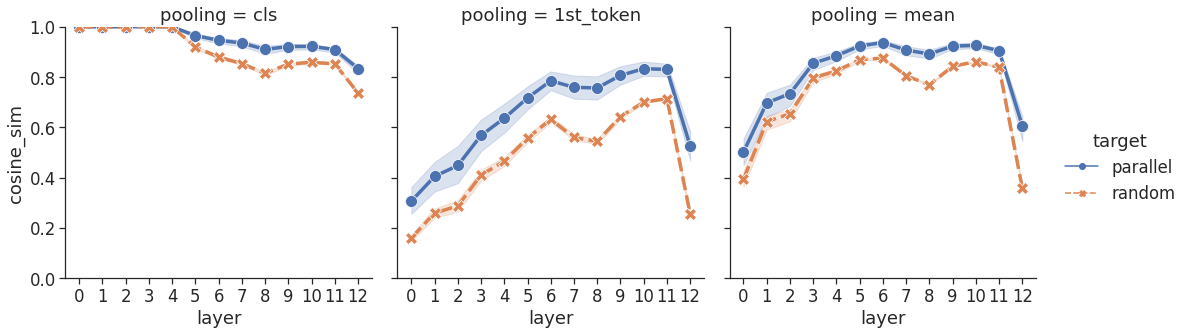

In [123]:
g = sns.relplot(data=cos_df, 
            x="layer", 
            y="cosine_sim", 
            hue="target", 
            style="target", 
            markers=True, 
            col="pooling", 
            kind="line", 
            col_order=["cls", "1st_token", "mean"],
            linewidth=3.5,
            markersize=12)


plt.xticks(range(13))
plt.ylim(0,1)

g.tight_layout()

g.figure.savefig(f"../assets/cosine_top1_sim-xnli-{hf_model_id}.pdf", dpi=300)

# Representational Simiarity Analysis

In [32]:
from ecco import analysis

#### cls

In [141]:
%%time

scores_cka = defaultdict(list)
scores_svcca = defaultdict(list)
scores_pwcca = defaultdict(list)

src = datasets["en"].map(function=encode_batch, fn_kwargs={'field': 'hypo', 
                                                                     'tokenizer': tokenizer, 
                                                                     'model': model,
                                                                     'detok': True,
                                                                     'lang_code': "en",
                                                                     "encode_token1": False,
                                                                     "encode_cls": True},
                              batched=True,
                              batch_size=3000)

for lang in langs:
    print(f"\n{lang}")

    if lang == "en":
        continue

    tgt = datasets[lang].map(function=encode_batch, fn_kwargs={'field': 'hypo', 
                                                                         'tokenizer': tokenizer, 
                                                                         'model': model, 
                                                                         'detok': True, 
                                                                         'lang_code': lang,
                                                                         "encode_token1": False,
                                                                         "encode_cls": True},
                                  batched=True,
                                  batch_size=3000)

    num_layers=13

    for l in range(num_layers):
        print(f"l{l}", end = ' ')
        if l == 0:
            scores_cka[lang].append(1)
            scores_svcca[lang].append(1)
            scores_pwcca[lang].append(1)
            continue

        reps1 = np.array(src[f'cls_{l}'])
        reps2 = np.array(tgt[f'cls_{l}'])
        
        reps1 -= reps1.mean(axis=1, keepdims=True)
        reps2 -= reps2.mean(axis=1, keepdims=True)
        
        scores_cka[lang].append(analysis.cka(reps1.T, reps2.T))
        scores_svcca[lang].append(analysis.svcca(reps1.T, reps2.T))
        scores_pwcca[lang].append(analysis.pwcca(reps1.T, reps2.T))

Loading cached processed dataset at /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-e88fcd2517069a4d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-4efe1643e7b22820.arrow



en

fr


Loading cached processed dataset at /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-e3dda5d3fce092d1/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-a746e393ed6b119d.arrow


l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 
de


Loading cached processed dataset at /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-1bd607b7aa1a4f75/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-734bac3801690e76.arrow


l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 
et


Loading cached processed dataset at /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-76b0f6a318f5e020/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-95b57f29b4ac7132.arrow


l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 
ru


Loading cached processed dataset at /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-32db336b4c4e85b8/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-9d9fe9c83bc24093.arrow


l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 CPU times: user 26min 41s, sys: 43 s, total: 27min 24s
Wall time: 16min 41s


In [142]:
scores_cka_df = pd.DataFrame(scores_cka)
scores_cka_df["layer"] = scores_cka_df.index
scores_cka_df["algo"] = "cka"
scores_cka_df = scores_cka_df.melt(value_name="score", var_name="lang", id_vars=["algo", "layer"])

scores_pwcca_df = pd.DataFrame(scores_pwcca)
scores_pwcca_df["layer"] = scores_pwcca_df.index
scores_pwcca_df["algo"] = "pwcca"
scores_pwcca_df = scores_pwcca_df.melt(value_name="score", var_name="lang", id_vars=["algo", "layer"])

scores_svcca_df = pd.DataFrame(scores_svcca)
scores_svcca_df["layer"] = scores_svcca_df.index
scores_svcca_df["algo"] = "svcca"
scores_svcca_df = scores_svcca_df.melt(value_name="score", var_name="lang", id_vars=["algo", "layer"])

scores_cls_df = pd.concat([scores_pwcca_df, scores_svcca_df, scores_cka_df], ignore_index=True)

In [143]:
scores_cls_df = scores_cls_df[scores_cls_df["layer"] != 0]

In [69]:
scores_cls_df.to_csv("../assets/cca_likes-cls.csv", index=False)

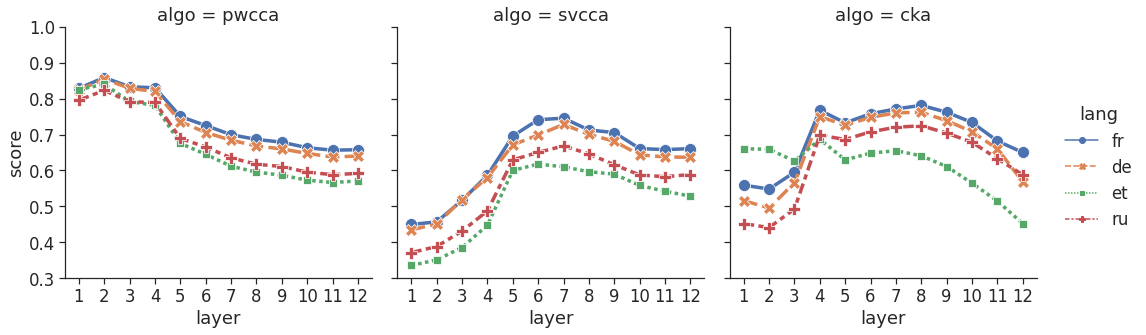

In [144]:
g = sns.relplot(data=scores_cls_df, x="layer", y="score", col="algo", kind="line", hue="lang", style="lang", markers=True,
            linewidth=3.5,
            markersize=12)

plt.xticks(range(1,13))
plt.ylim(0.3, 1)

g.tight_layout()

#g.figure.savefig(f"../assets/metrics_cls-{hf_model_id}.pdf", dpi=300)

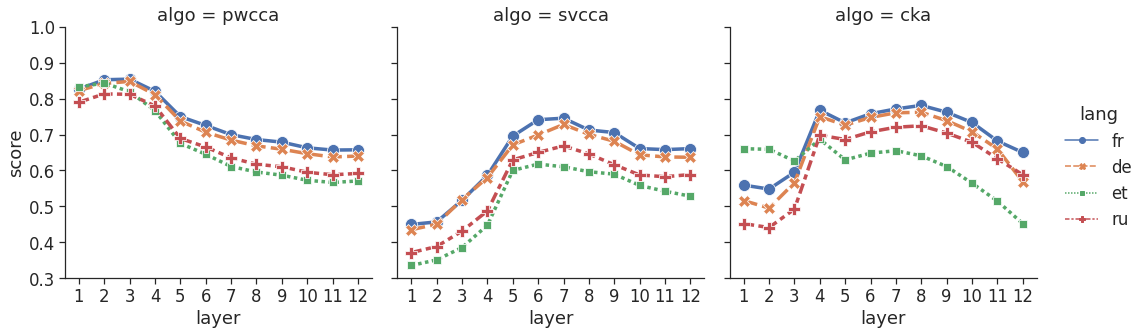

In [124]:
g = sns.relplot(data=scores_cls_df, x="layer", y="score", col="algo", kind="line", hue="lang", style="lang", markers=True,
            linewidth=3.5,
            markersize=12)

plt.xticks(range(1,13))
plt.ylim(0.3, 1)

g.tight_layout()

#g.figure.savefig(f"../assets/metrics_cls-{hf_model_id}.pdf", dpi=300)

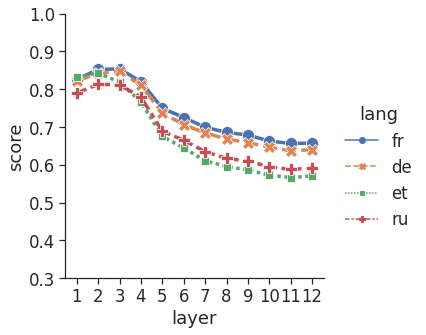

In [125]:

g = sns.relplot(data=scores_cls_df[scores_cls_df["algo"] == "pwcca"], 
                x="layer", y="score", kind="line", hue="lang", style="lang", markers=True,
            linewidth=3.5,
            markersize=12)

plt.xticks(range(1,13))
plt.ylim(0.3, 1)

g.tight_layout()
g.figure.savefig(f"../assets/pwcca_cls-{hf_model_id}.pdf", dpi=300)

#### mean

In [63]:
%%time

scores_cka = defaultdict(list)
scores_svcca = defaultdict(list)
scores_pwcca = defaultdict(list)

src = datasets["en"].map(function=encode_batch, fn_kwargs={'field': 'hypo', 
                                                                     'tokenizer': tokenizer, 
                                                                     'model': model,
                                                                     'detok': True,
                                                                     'lang_code': "en",
                                                                     "encode_token1": False,
                                                                     "encode_cls": True},
                              batched=True,
                              batch_size=3000)

for lang in langs:
    print(f"\n{lang}")

    if lang == "en":
        continue

    tgt = datasets[lang].map(function=encode_batch, fn_kwargs={'field': 'hypo', 
                                                                         'tokenizer': tokenizer, 
                                                                         'model': model, 
                                                                         'detok': False, 
                                                                         'lang_code': lang,
                                                                         "encode_token1": False,
                                                                         "encode_cls": True},
                                  batched=True,
                                  batch_size=3000)

    num_layers=13

    for l in range(num_layers):
        print(f"l{l}", end = ' ')
        reps1 = np.array(src[f'mean_{l}'])
        reps2 = np.array(tgt[f'mean_{l}'])
        
        scores_cka[lang].append(analysis.cka(reps1.T, reps2.T))
        scores_svcca[lang].append(analysis.svcca(reps1.T, reps2.T))
        scores_pwcca[lang].append(analysis.pwcca(reps1.T, reps2.T))

Loading cached processed dataset at /gpfs/space/home/maksym95/.cache/huggingface/datasets/csv/default-e88fcd2517069a4d/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e/cache-4efe1643e7b22820.arrow



en

fr


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 
de


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 
et


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 
ru


  0%|          | 0/4 [00:00<?, ?ba/s]

l0 l1 l2 l3 l4 l5 l6 l7 l8 l9 l10 l11 l12 CPU times: user 29min 12s, sys: 58.6 s, total: 30min 10s
Wall time: 18min 30s


In [64]:
scores_cka_df = pd.DataFrame(scores_cka)
scores_cka_df["layer"] = scores_cka_df.index
scores_cka_df["algo"] = "cka"
scores_cka_df = scores_cka_df.melt(value_name="score", var_name="lang", id_vars=["algo", "layer"])

scores_pwcca_df = pd.DataFrame(scores_pwcca)
scores_pwcca_df["layer"] = scores_pwcca_df.index
scores_pwcca_df["algo"] = "pwcca"
scores_pwcca_df = scores_pwcca_df.melt(value_name="score", var_name="lang", id_vars=["algo", "layer"])

scores_svcca_df = pd.DataFrame(scores_svcca)
scores_svcca_df["layer"] = scores_svcca_df.index
scores_svcca_df["algo"] = "svcca"
scores_svcca_df = scores_svcca_df.melt(value_name="score", var_name="lang", id_vars=["algo", "layer"])

scores_mean_df = pd.concat([scores_pwcca_df, scores_svcca_df, scores_cka_df], ignore_index=True)

In [67]:
scores_mean_df.to_csv("../assets/cca_likes-mean.csv", index=False)

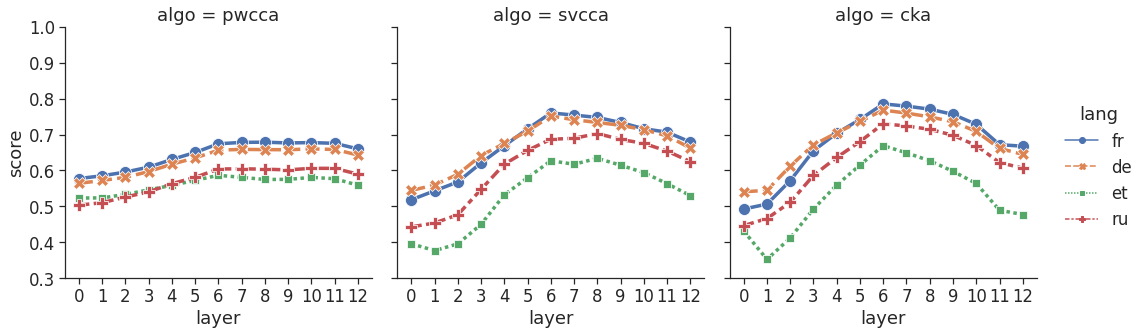

In [126]:
g = sns.relplot(data=scores_mean_df, x="layer", y="score", col="algo", kind="line", hue="lang", style="lang", markers=True,
            linewidth=3.5,
            markersize=12)

plt.xticks(range(0,13))
plt.ylim(0.3, 1)

g.tight_layout()
g.figure.savefig(f"../assets/metrics_mean-{hf_model_id}.pdf", dpi=300)

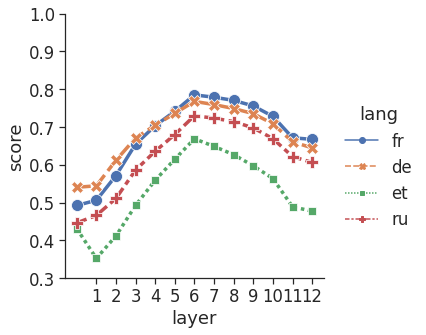

In [127]:

g = sns.relplot(data=scores_mean_df[scores_mean_df["algo"] == "cka"], 
                x="layer", y="score", kind="line", hue="lang", style="lang", markers=True,
            linewidth=3.5,
            markersize=12)

plt.xticks(range(1,13))
plt.ylim(0.3, 1)

g.tight_layout()
g.figure.savefig(f"../assets/cka_mean-{hf_model_id}.pdf", dpi=300)

In [133]:
g.set_titles??

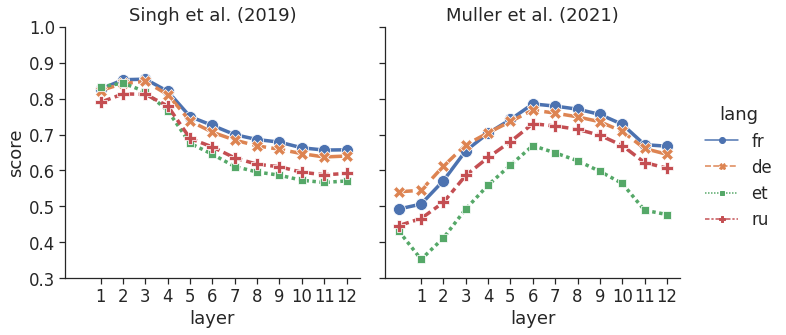

In [137]:
confl_df = pd.concat([scores_mean_df[scores_mean_df["algo"] == "cka"], 
                      scores_cls_df[scores_cls_df["algo"] == "pwcca"]], 
                     ignore_index=True)

g = sns.relplot(data=confl_df, 
                x="layer", y="score", kind="line", hue="lang", style="lang", markers=True, col="algo",
                col_order=["pwcca", "cka"],
            linewidth=3.5,
            markersize=12)

plt.xticks(range(1,13))
plt.ylim(0.3, 1)

axes = g.axes.flatten()
axes[0].set_title("Singh et al. (2019)")
axes[1].set_title("Muller et al. (2021)")

g.tight_layout()
g.figure.savefig(f"../assets/confl-{hf_model_id}.pdf", dpi=300)